**This notebook focuses on performing sentiment analysis on the OLID dataset using two methods. The first method is an LSTM-based classifier, while the second method is a BERT-based classifier. The goal is to classify the tweets in the dataset into offensive and non-offensive categories accurately. We will train and evaluate both classifiers and compare their performance on the OLID dataset. Additionally, we will explore the impact of varying the size of the training data on the performance of the classifiers.**

Inspiration taken from:
1. https://www.kaggle.com/code/derrelldsouza/imdb-sentiment-analysis-eda-ml-lstm-bert/notebook

2. https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertForSequenceClassification



Importing the necessary libraries and setting up the Google Drive and the respective directories for each task. This will help us to access the required files and datasets conveniently.

In [ ]:
import pandas as pd
import numpy as np
import os
import shutil

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.7 MB/s eta 0:00:00


In [ ]:
# import the required libraries:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

import seaborn as sns
import matplotlib.pyplot as plt

import re
import pickle

import torch
from transformers import BertTokenizerFast
from transformers import BertForSequenceClassification
from transformers import Trainer,TrainingArguments

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In the next code block will make our new working directories in our google drive and also will upload the dataset files for later use.
The dataset files inclue:
*   Train File
*   Test File
*   Valid File



In [ ]:


# The student id will let us determine the fixed random seed for operations
student_id=10
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = os.path.join('./CE807/Assignment2/',str(student_id)) # Make sure to update with your student_id and student_id is an integer
GOOGLE_DRIVE_PATH = os.path.join('gdrive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)


# main path where data will be placed.
if not os.path.exists(GOOGLE_DRIVE_PATH):
  os.makedirs(GOOGLE_DRIVE_PATH)

# Let also make model directory for later use

models=['1','2']
train_size_data=['25','50','75','100']

for model in models:
  for ds in train_size_data:
    path=os.path.join(GOOGLE_DRIVE_PATH,'models',model,ds)
    print(path)
    if not os.path.exists(path):
      os.makedirs(path)

tr_p=os.path.join(GOOGLE_DRIVE_PATH, 'train.csv')
ts_p=os.path.join(GOOGLE_DRIVE_PATH, 'test.csv')
val_p=os.path.join(GOOGLE_DRIVE_PATH, 'valid.csv')


gdrive/MyDrive/./CE807/Assignment2/10/models/1/25
gdrive/MyDrive/./CE807/Assignment2/10/models/1/50
gdrive/MyDrive/./CE807/Assignment2/10/models/1/75
gdrive/MyDrive/./CE807/Assignment2/10/models/1/100
gdrive/MyDrive/./CE807/Assignment2/10/models/2/25
gdrive/MyDrive/./CE807/Assignment2/10/models/2/50
gdrive/MyDrive/./CE807/Assignment2/10/models/2/75
gdrive/MyDrive/./CE807/Assignment2/10/models/2/100


For First running the notebook uncomment the below code to place the files in google drive. First upload the dataset files to the colab session. When the files are uploaded keep we can then leave the next code cell commented out.

In [ ]:
# train=pd.read_csv("/content/train.csv")
# test=pd.read_csv("/content/test.csv")
# valid=pd.read_csv("/content/valid.csv")

# train.to_csv(tr_p,index=False)
# test.to_csv(ts_p,index=False)
# valid.to_csv(val_p,index=False)

In [ ]:
#setting up the random seed
np.random.seed(student_id)
tf.random.set_seed(student_id)
torch.manual_seed(student_id)
torch.cuda.manual_seed(student_id)


**Model Selection TASK1**

I have pinpointed two sentiment classifiers that I will be training on the OLID Dataset. These classifiers include a LSTM-based classifier and a transformer-based BERT classifier.

The LSTM classifier utilizes a neural network architecture that is well-suited for sequential data, making it a good fit for natural language tasks. The model will be built using Keras and TensorFlow architecture.

The BERT classifier, being a bidirectional transformer, can be fine-tuned for downstream NLP tasks. In this project, I will be using the BertForSequenceClassification model with the original weights from bert-base-uncased and fine-tune it according to our needs. The model will be imported from the Hugging Face transformer libraries.

**TASK 2 Training and EDA of DATASET**

Before starting the task of training the sentiment classifiers, it is important to look into the dataset files to understand the statistics and characteristics of the dataset we are working with.



---





In [ ]:

ds_tr=pd.read_csv(tr_p)
ds_ts=pd.read_csv(ts_p)
ds_val=pd.read_csv(val_p)

In [ ]:
# printing few rows of our dataset
print(ds_tr.head())
print(ds_ts.head())
ds_val.head()

      id                                              tweet label
0  42884  @USER I’m done with you as well. An INTENTIONA...   NOT
1  92152  I now have over 6k followers.  Only 94k to go ...   NOT
2  65475  @USER Tom was bought! He is more interested in...   NOT
3  22144  @USER @USER Even her brother thinks she is a m...   OFF
4  81048  @USER @USER @USER @USER @USER I can understand...   OFF
      id                                              tweet label
0  15923  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...   OFF
1  27014  #ConstitutionDay is revered by Conservatives, ...   NOT
2  30530  #FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...   NOT
3  13876  #Watching #Boomer getting the news that she is...   NOT
4  60133  #NoPasaran: Unity demo to oppose the far-right...   OFF


,id,tweet,label
0,12476,@USER @USER @USER Trump is declassifying infor...,NOT
1,23242,@USER Ha even with them trying to rig the syst...,NOT
2,97885,@USER @USER @USER Man you really thought this ...,NOT
3,43414,@USER Ms. Clinton - you are a class act. My re...,OFF
4,81403,@USER It’s still here at 753. If someone did t...,NOT


In [ ]:
ds_tr.shape,ds_ts.shape,ds_val.shape

((12313, 3), (860, 3), (927, 3))

As we can see, the tweets in our dataset need to be preprocessed and cleaned before we can proceed with training the sentiment classifiers. To achieve this, we will follow these steps:

We will filter out non-English text and only keep the English text in our tweets.
We will remove any special characters and punctuation marks from the text.
We will remove any tags (such as @ and #) and their suffixes, as well as any URLs or links from our tweets

In [ ]:
# Writing cleaning tweet functions:
def clean_tweet(ds_tr):
  ds_tr['tweet'] = ds_tr['tweet'].apply(lambda x: x.lower())
  ds_tr['tweet']= ds_tr['tweet'].apply(lambda x:re.sub(r'\#[^\s]+','',x))
  ds_tr['tweet'] = ds_tr['tweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
  ds_tr['tweet'] = ds_tr['tweet'].apply(lambda x:x.strip())
  ds_tr['tweet'] = ds_tr['tweet'].str.replace("user","")
  ds_tr['tweet'] = ds_tr['tweet'].str.replace("url","")
  return ds_tr['tweet']


In [ ]:
ds_tr['tweet']=clean_tweet(ds_tr)
ds_ts['tweet']=clean_tweet(ds_ts)
ds_val['tweet']=clean_tweet(ds_val)

In [ ]:
for i in range(0,5):
  print(ds_tr['tweet'][i])

 im done with you as well an intentional 11th hour attack completely based on hearsay and you want an investigation what do you think theyll find other than he said she said feinstein admitted she sat on this and here you are ready to lockstep with the swamp
i now have over 6k followers  only 94k to go to get to my goal
 tom was bought he is more interested in tom than his constituents
  even her brother thinks she is a monster 
     i can understand that and if its someone i know ill debate with them but im not willing to spend that much time trying to change the mind of someone i dont know i tryed that with people and gun control and it just get stupid because they wont try to understand


Now that the text is cleaned, we can proceed with visualizing the data. This will help us understand the underlying features of the dataset and its class distribution. We will primarily conduct our analysis on the train dataset, as this will give us a better understanding of the OLID dataset.

First we will see tweet sequence length and class distrubution.


<ipython-input-45-84c2d0f32100>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(p_word, ax=ax1,color='blue')
<ipython-input-45-84c2d0f32100>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(n_word,ax=ax2,color='yellow')


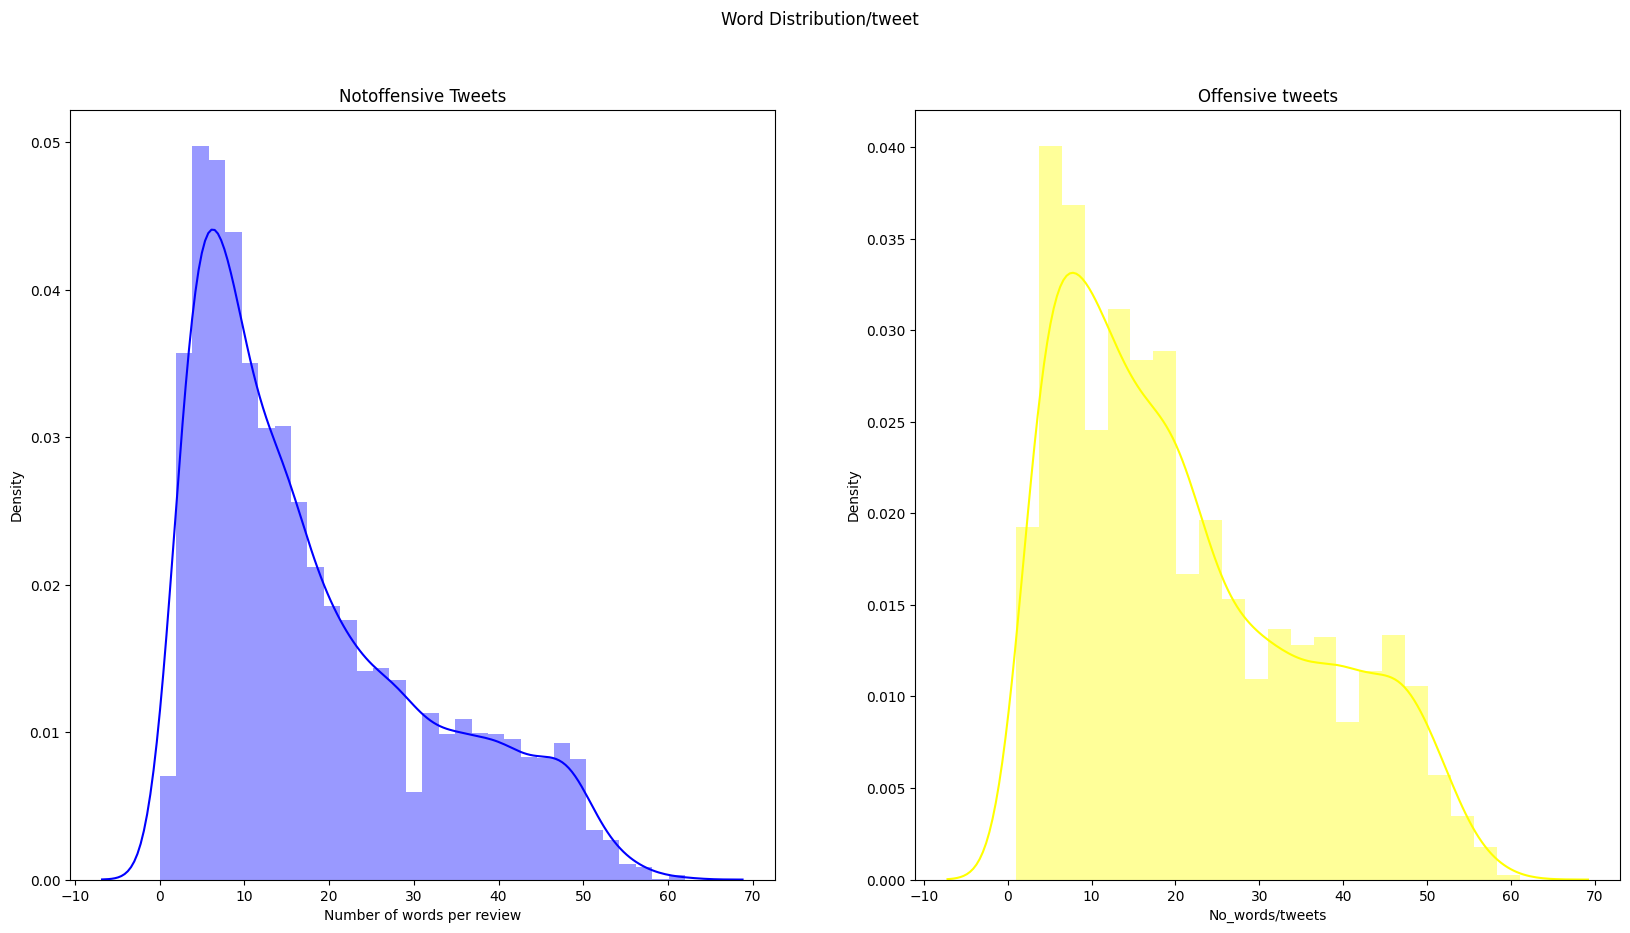

In [ ]:
tweets_negative=ds_tr[ds_tr['label']=='OFF']
tweets_positive=ds_tr[ds_tr['label']=='NOT']

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
p_word = tweets_positive['tweet'].apply(lambda x:len(x.split()))      # .str.split().apply(lambda x : len(x) )
sns.distplot(p_word, ax=ax1,color='blue')
ax1.set_title('Notoffensive Tweets')
ax1.set_xlabel('Number of words per review')
n_word = tweets_negative['tweet'].apply(lambda x:len(x.split()))
sns.distplot(n_word,ax=ax2,color='yellow')
ax2.set_title('Offensive tweets')
ax2.set_xlabel('No_words/tweets')
fig.suptitle('Word Distribution/tweet')
plt.show()

NOT    8221
OFF    4092
Name: label, dtype: int64


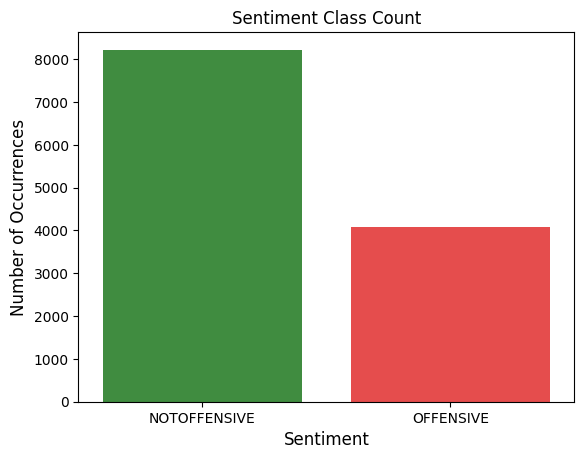

In [ ]:
v_c=ds_tr['label'].value_counts()
print(v_c)
sns.barplot(x=v_c.index, y=v_c.values, alpha=0.8,palette=['green','red'])
plt.title('Sentiment Class Count')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel("Sentiment",fontsize=12)
plt.xticks(ticks = np.arange(2),labels = ['NOTOFFENSIVE','OFFENSIVE'])
plt.show()

 It appears that our dataset has a class imbalance, as the number of non-offensive tweets is greater than that of offensive ones. This can potentially affect the performance of our sentiment classifiers, as they may not be able to accurately classify offensive tweets due to the lack of representation in the dataset.


We will start the machine learning phase by using the entire training dataset to train the LSTM-based classifier first. Later, for TASK 3, we will split the data into training and testing sets of different sizes to evaluate the performance of the classifiers.

In [ ]:

# setting up model accuracy,loss plot both for training and validation dataset
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig , ax = plt.subplots(1,2,figsize = (10,5))
  
  ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()
  ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  fig.tight_layout()
  plt.show()

In [ ]:
# Defining function to encode our target label

def L_enc(dataframe):
  dataframe['label']=dataframe['label'].replace(['OFF','NOT'],[0,1]).astype(int)
  return dataframe['label']

In [ ]:
ds_tr['label']=L_enc(ds_tr)
ds_ts['label']=L_enc(ds_ts)
ds_val['label']=L_enc(ds_val)

x_tr, y_tr = ds_tr['tweet'], ds_tr['label']
x_ts, y_ts = ds_ts['tweet'], ds_ts['label']

x_val, y_val = ds_val['tweet'], ds_val['label']

Defining the LSTM model

In [ ]:

def lstm_model(x_tr,Xval,y_tr,yval,V,D,maxlen,epochs):

    print("----Building the model----")
    i = Input(shape=(maxlen,))
    mdx = Embedding(V + 1, D,input_length = maxlen)(i)
    mdx = BatchNormalization()(mdx)
    mdx = Dropout(0.3)(mdx)
    mdx = Conv1D(32,5,activation = 'relu')(mdx)
    mdx = Dropout(0.3)(mdx)
    mdx = MaxPooling1D(2)(mdx)
    mdx = Bidirectional(LSTM(128,return_sequences=True))(mdx)
    mdx = LSTM(64)(mdx)
    mdx = Dropout(0.5)(mdx)
    mdx = Dense(1, activation='sigmoid')(mdx)
    model = Model(i, mdx)
    model.summary()

    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    res = model.fit(x_tr,y_tr, 
                  validation_data = (Xval,yval), 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(x_tr,y_tr))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(res.history['loss'])
    
    return res,model,n_epochs 

Now we will train our tokenizer for LSTM model on our train dataset vocabulary.
The tokenizer is taken from keras text preprocessing module.
This will enocode our tweet in numerical representation

In [ ]:
MAX_VOCAB_SIZE = 15000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tokenizer.fit_on_texts(x_tr)
idx_wrd = tokenizer.word_index
#print(idx_wrd)
V = len(idx_wrd)

In [ ]:
sq_tr = tokenizer.texts_to_sequences(x_tr)
sq_ts =  tokenizer.texts_to_sequences(x_ts)
sq_val=tokenizer.texts_to_sequences(x_val)

In [ ]:
# The tokenized sequences:
sq_tr[0],sq_tr[1]

([78,
  242,
  21,
  7,
  32,
  117,
  57,
  5867,
  2950,
  1617,
  420,
  580,
  839,
  18,
  8259,
  6,
  7,
  86,
  57,
  897,
  30,
  43,
  7,
  73,
  1367,
  335,
  116,
  90,
  11,
  128,
  15,
  128,
  840,
  2655,
  15,
  1813,
  18,
  17,
  6,
  138,
  7,
  9,
  782,
  4,
  5868,
  21,
  2,
  928],
 [10, 74, 22, 113, 8260, 898, 83, 8261, 4, 88, 4, 62, 4, 55, 1307])



---
---


They have varying shape according to the size of tweet size.
We have to make them of equal size so we will pad the sequences.

In [ ]:
# lets set sequence length
mx_sq_l=55

In [ ]:
#create padded sequences
p_ts=pad_sequences(sq_ts,truncating = 'post', padding = 'pre',maxlen=mx_sq_l)
p_val=pad_sequences(sq_val,truncating = 'post', padding = 'pre',maxlen=mx_sq_l)
p_tr=pad_sequences(sq_tr,truncating = 'post', padding = 'pre',maxlen=mx_sq_l)

x_ts=p_ts
x_val=p_val
x_tr=p_tr


In [ ]:
D = 64 #embedding dims
epochs = 5
res,lstm_model,number_epochs = lstm_model(x_tr,x_val,y_tr,y_val,V,D,mx_sq_l,epochs)

----Building the model----
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 55)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 55, 64)            1173760   
                                                                 
 batch_normalization_2 (Batc  (None, 55, 64)           256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 55, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 51, 32)            10272     
                                                                 
 dropout_4 (Dropout)         (None, 51, 32)            0         
                                

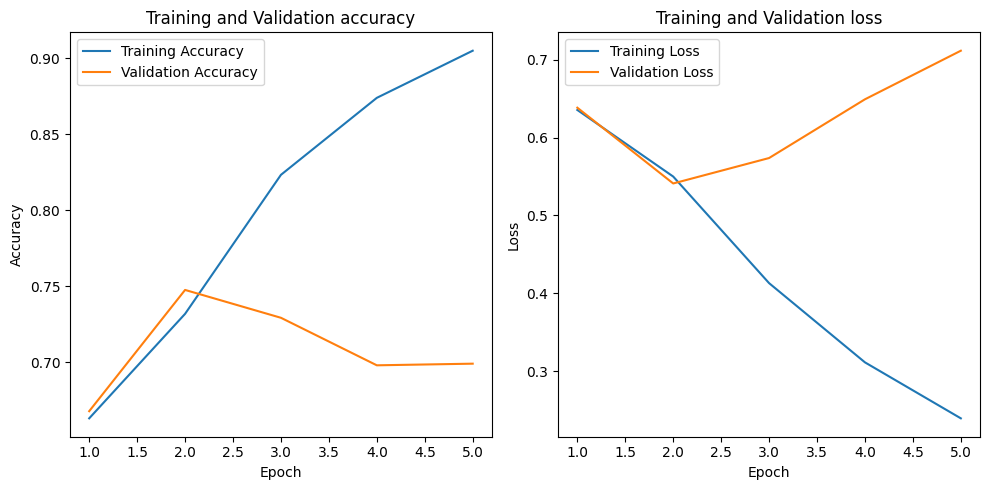

In [ ]:
# Now we will call the function that we declare above
plotLearningCurve(res,number_epochs)

Now will test our model on test dataset


In [ ]:
print("Evaluate Model Performance on Test set")
result = lstm_model.evaluate(p_ts,y_ts)
print(dict(zip(lstm_model.metrics_names, result)))

Evaluate Model Performance on Test set
27/27 [==============================] - 0s 7ms/step - loss: 0.6366 - accuracy: 0.7291
{'loss': 0.636580765247345, 'accuracy': 0.7290697693824768}


 We will now plot the confusion matrix see the model performance on each class.

27/27 [==============================] - 0s 12ms/step


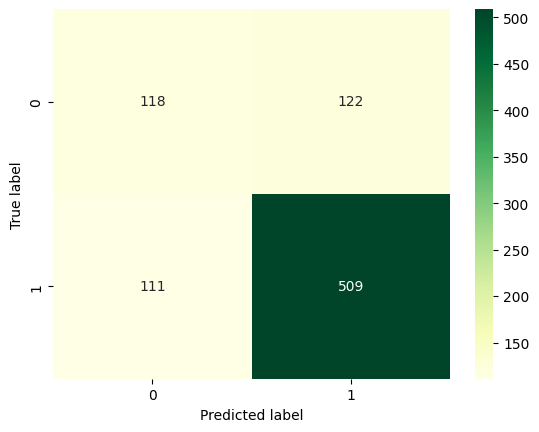

In [ ]:
#Generate predictions for the test dataset
y_prediction = lstm_model.predict(p_ts)
y_prediction = y_prediction>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(y_ts, y_prediction)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='YlGn')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


After training and evaluating the LSTM-based classifier, we observed a confusion matrix that showed better prediction performance for label 1 compared to label 0. This can be attributed to the class imbalance issue that we have already observed earlier, where the number of non-offensive tweets is significantly greater than that of offensive tweets. As a result, the classifier is more likely to predict a tweet as non-offensive, leading to a higher number of true positives and true negatives for label 1, but a lower number for label 0.




**Bert-base classifier Model**

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
def df_extract(dataframe):
  return dataframe['tweet'],dataframe['label']

In [ ]:
x_tr, y_tr = df_extract(ds_tr)
x_ts, y_ts = df_extract(ds_ts)
Xval, yval = df_extract(ds_val)


In [ ]:
# Just verifying the data
x_tr[0],x_tr.shape

(' im done with you as well an intentional 11th hour attack completely based on hearsay and you want an investigation what do you think theyll find other than he said she said feinstein admitted she sat on this and here you are ready to lockstep with the swamp',
 (12313,))

In [ ]:
# Now we tokenize our tweet using bert tokenizer

In [ ]:
x_tr_inp = tokenizer(x_tr.tolist(),padding="max_length",truncation=True,max_length=128)
x_ts_inp=tokenizer(x_ts.tolist(),padding="max_length",truncation=True,max_length=128)
val_inp = tokenizer(Xval.tolist(),padding="max_length",truncation=True,max_length=128)

val_inp.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
# Now will convert our dataset into torch data_type

In [ ]:
class torch_ds(torch.utils.data.Dataset):
  def __init__(self,encodings,labels):
    self.encodings=encodings
    self.labels=labels
  
  def __getitem__(self,idx):
    item = {key:torch.tensor(val[idx]) for key,val in self.encodings.items()}
    item["labels"] = torch.tensor(self.labels[idx])
    return item
  def __len__(self):
    return len(self.labels)

tr_torchds = torch_ds(x_tr_inp,y_tr.tolist())
val_torchds=torch_ds(val_inp,yval.tolist())

Lets see how our model prediction on our test data without finetuning it.

In [ ]:

def test_predop1(input_ids,attention_mask,model):
  input_ids = torch.tensor(input_ids).to(device)
  attention_mask = torch.tensor(attention_mask).to(device)
  with torch.no_grad():
      outputs = model(input_ids.unsqueeze(0),attention_mask.unsqueeze(0))
  y = np.argmax(outputs[0].to('cpu').numpy())
  y_prob = torch.nn.functional.softmax(outputs[0],dim=-1)[0][y].to('cpu').numpy()
  return y,y_prob

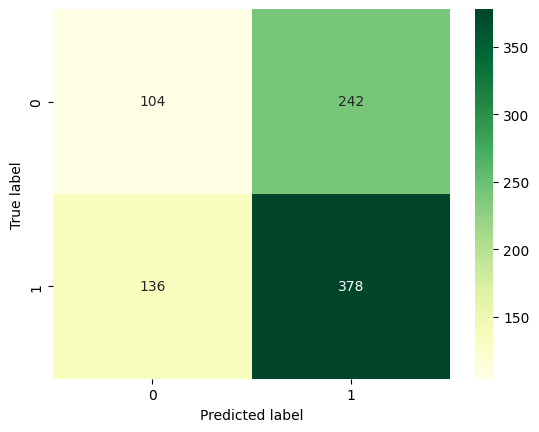

In [ ]:
predictions_test=[]
for i in range(len(x_ts_inp['input_ids'])) :
  op,p_op = test_predop1(x_ts_inp['input_ids'][i],x_ts_inp['attention_mask'][i],model)
  predictions_test.append(op)

cf_matrix = confusion_matrix(predictions_test, y_ts)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='YlGn')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Poor results from base model



Training Part

In [ ]:
training_args = TrainingArguments(
    #overwrite_output_dir=True,
    #evaluation_strategy='epoch',
    #load_best_model_at_end=True,
    output_dir='None',
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=250,
    weight_decay=0.01,
    logging_steps=100,
    

)
trainer = Trainer(model=model,args=training_args,train_dataset=tr_torchds,eval_dataset=val_torchds
    )
trainer.train()


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
100,0.641600
200,0.479100
300,0.467600
400,0.434100
500,0.356700
600,0.352900
700,0.344500


TrainOutput(global_step=770, training_loss=0.4303069449090338, metrics={'train_runtime': 482.8549, 'train_samples_per_second': 51.001, 'train_steps_per_second': 1.595, 'total_flos': 1619843212323840.0, 'train_loss': 0.4303069449090338, 'epoch': 2.0})

In [ ]:
shutil.rmtree('/content/None')
trainer.state.log_history[-1]

{'train_runtime': 482.8549,
 'train_samples_per_second': 51.001,
 'train_steps_per_second': 1.595,
 'total_flos': 1619843212323840.0,
 'train_loss': 0.4303069449090338,
 'epoch': 2.0,
 'step': 770}

 Prediction after training

In [ ]:
predictions_test=[]
for i in range(len(x_ts_inp['input_ids'])) :
  op,p_op = test_predop1(x_ts_inp['input_ids'][i],x_ts_inp['attention_mask'][i],model)
  predictions_test.append(op)


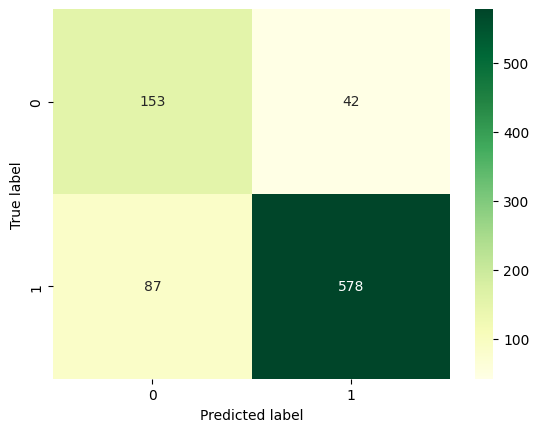

In [ ]:
cf = confusion_matrix(predictions_test, y_ts)
sns.heatmap(cf,annot = True,fmt ='g', cmap='YlGn')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

The results improve drastically after fine tuning our model.
lets also print the classification report which contain all the necessary metrics to judge our results.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(predictions_test, y_ts, target_names=['Offensive','Notoffensive']))

              precision    recall  f1-score   support

   Offensive       0.64      0.78      0.70       195
Notoffensive       0.93      0.87      0.90       665

    accuracy                           0.85       860
   macro avg       0.78      0.83      0.80       860
weighted avg       0.87      0.85      0.86       860



In [ ]:
accuracy_score(predictions_test,y_ts)

0.85

**Task 3**
Training on different data sizes:
1. 25%
2. 50%
3. 75%
4. 100%
method 1 is for LSTM classifier.
method 2 is for BERT classifier.

Most of the workflow for the upcoming task will be taken from Task 2, but it will be wrapped in functions for better organization and reusability. This will help to avoid code repetition and make the code more modular and easy to maintain.

In [ ]:
def plot_confusion_matrix(predictions_test,y_ts,model_directory):
  cf_matrix = confusion_matrix(predictions_test, y_ts)
  sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='YlGn')
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  title=model_directory.split("/")[-1]
  plt.title(f"Model For Train Data {title} %")
  plt.show()

def reading_dataset(tr_p,ts_p,val_p):
  
  train_file=pd.read_csv(tr_p)
  test_file=pd.read_csv(ts_p)
  val_file=pd.read_csv(val_p)

  return train_file,test_file,val_file

def cl_enc(dataframe):
  dataframe['tweet'] = dataframe['tweet'].apply(lambda x: x.lower())
  dataframe['tweet']= dataframe['tweet'].apply(lambda x:re.sub(r'\#[^\s]+','',x))
  dataframe['tweet'] = dataframe['tweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
  dataframe['tweet'] = dataframe['tweet'].apply(lambda x:x.strip())
  dataframe['tweet'] = dataframe['tweet'].str.replace("user","")
  dataframe['tweet'] = dataframe['tweet'].str.replace("url","")

  dataframe['label']=dataframe['label'].replace(['OFF','NOT'],[0,1]).astype(int)
  return dataframe




Will use split train data with stratification


In [ ]:
def sp_funct(train_file,model_directory):
  X,y=train_file['tweet'],train_file['label']
  x,xt, y,yt= train_test_split(X,y, test_size=0.5, random_state=student_id,stratify=y)


  x1,x2, y1,y2= train_test_split(x,y, test_size=0.5, random_state=student_id,stratify=y)

  x3,x4,y3,y4=train_test_split(xt,yt, test_size=0.5, random_state=student_id,stratify=yt)

  tr_25=x1
  tr_y25=y1
  
  tr_50=pd.concat([x1,x2])
  tr_y50=pd.concat([y1,y2])

  tr_75=pd.concat([x1,x2,x3])
  tr_y75=pd.concat([y1,y2,y3])

  tr_100=pd.concat([x1,x2,x3,x4])
  tr_y100=pd.concat([y1,y2,y3,y4])

  print("The shape of vary train data are:")
  print(f"25% train_data:{tr_25.shape}\n50% train_data:{tr_50.shape}\n75% train_data:{tr_75.shape}\n100% train_data:{tr_100.shape}")

  if model_directory.split("/")[-1]=='25':
    return tr_25,tr_y25
  if model_directory.split("/")[-1]=='50':
    return tr_50,tr_y50
  if model_directory.split("/")[-1]=='75':
    return tr_75,tr_y75
  if model_directory.split("/")[-1]=='100':
    return tr_100,tr_y100

  


In [ ]:

# Now defining our model initiliazer and training loop.

def meth1_my_LSTM(x_tr,Xval,y_tr,yval,V,D,maxlen,epochs,model_dir):
    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    print('Setting up the conv layer')
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.4)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.4)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()

    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0004),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint(model_dir, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True, 
    mode='auto'
)  
    r = model.fit(x_tr,y_tr, 
                  validation_data = (Xval,yval), 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32,
                  callbacks = [checkpoint])
    
    print("Train score:", model.evaluate(x_tr,y_tr))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

def meth1_plotLearningCurve(history,epochs,model_dir):
  epochRange = range(1,epochs+1)
  fig , ax = plt.subplots(1,2,figsize = (10,5))
  
  ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()
  ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  fig.tight_layout()
  title=model_dir.split("/")[-1]
  fig. suptitle(f"Model For Train Data {title} %", fontsize=5)
  plt.show()


In [ ]:
# Setting up functions for LSTM's tokenizer 

In [ ]:
def mehod1_tokenizer_train(Tokenizer,train_data):
  MAX_VOCAB_SIZE = 15000
  tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
  tokenizer.fit_on_texts(train_data)
  idx_wrd = tokenizer.word_index
  #print(idx_wrd)
  V = len(idx_wrd)

  return tokenizer,V

def mehod1_seq_tokenize(tweets,tokenizer):
  seq_tokenized = tokenizer.texts_to_sequences(tweets)
  seq_tokenized_padded=pad_sequences(seq_tokenized,truncating = 'post', padding = 'pre',maxlen=55)
  return seq_tokenized_padded


Now will defing training method1 which will take train_file,val_file,model_dir as function argument.

model_dir path will be used to save BEST model in specific directory and also will be use to determine the train data size.

In [ ]:
def train_method1(train_file,val_file,model_dir):
  
  x_tr,y_tr=sp_funct(train_file,model_dir)
  print(x_tr)
  
  print("---------")
  tokenizer,V=mehod1_tokenizer_train(Tokenizer,x_tr)

  #saving tokenizer
  tokenizer_path=os.path.join(model_dir,'tokenizer.pickle')
  with open(tokenizer_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  
  print('vocab',V)
  x_tr_tokenized_padded=mehod1_seq_tokenize(x_tr,tokenizer)
  
  vl_tweet , vl_label=val_file['tweet'],val_file['label']
  val_padded_seq=mehod1_seq_tokenize(vl_tweet,tokenizer)
  
  #return x_tr_tokenized_padded,y_tr,val_padded_seq,vl_label
  
  D = 64 #embedding dims
  epochs = 4
  r,model,n_epochs = meth1_my_LSTM(x_tr_tokenized_padded,val_padded_seq,y_tr,vl_label,V,D,55,epochs,model_dir)
  print("-------------------------------------------------")
  meth1_plotLearningCurve(r,n_epochs,model_dir)
  print("Saving model to the model directory",model_dir)
  model.save(model_dir)
  #return x_tr_tokenized_padded,val_padded_seq  
  




The test methods is specific to the model and will be used to evaluate predictions for test dataset. It will also print confusion matrix and classification report containinfg F1 , Precsion and Recall score etc.

The best saved model from train method is also loaded from its specific directory.

The final prediction will be saved in specific directory as "output.csv"

In [ ]:
def test_method1(test_file,model_file_dir,output):
  model=keras.models.load_model(model_file_dir)

  tokenizer_path=os.path.join(model_file_dir,'tokenizer.pickle')
  with open(tokenizer_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

  test_tweet , test_label=test_file['tweet'],test_file['label']
  test_pad_seq=mehod1_seq_tokenize(test_tweet,tokenizer)

  y_prediction = model.predict(test_pad_seq)
  y_prediction = y_prediction>0.5

  plot_confusion_matrix(y_prediction , test_label, model_file_dir)

  report_nondict=classification_report(y_prediction, test_label, target_names=['Offensive','Notoffensive'])
  
  print(report_nondict)
  report_dict=classification_report(y_prediction, test_label, target_names=['Offensive','Notoffensive'],output_dict=True)
  
  test_file['out_label']=y_prediction
  test_file['out_label']=test_file['out_label'].replace([0,1],['OFF','NOT'])
  print("------------")
  print(f"Saving output file to {model_file_dir}")
  output_directory=os.path.join(model_file_dir,output)
  test_file.to_csv(output_directory,index=False)
  return report_dict



In [ ]:
# Setting up the model directory.
model_directory1_100=f"gdrive/MyDrive/./CE807/Assignment2/{str(student_id)}/models/1/100"
model_directory1_75=f"gdrive/MyDrive/./CE807/Assignment2/{str(student_id)}/models/1/75"
model_directory1_50=f"gdrive/MyDrive/./CE807/Assignment2/{str(student_id)}/models/1/50"
model_directory1_25=f"gdrive/MyDrive/./CE807/Assignment2/{str(student_id)}/models/1/25"

In [ ]:
train_file,test_file,val_file=reading_dataset(tr_p,ts_p,val_p)

train_file=cl_enc(train_file)
test_file=cl_enc(test_file)
val_file=cl_enc(val_file)
print(train_file.head())





      id                                              tweet  label
0  42884   im done with you as well an intentional 11th ...      1
1  92152  i now have over 6k followers  only 94k to go t...      1
2  65475   tom was bought he is more interested in tom t...      1
3  22144          even her brother thinks she is a monster       0
4  81048       i can understand that and if its someone ...      0


The shape of vary train data are:
25% train_data:(3078,)
50% train_data:(6156,)
75% train_data:(9234,)
100% train_data:(12313,)
2896      hey   they all cant come to us  come on  we h...
11947     iya risi in my area didnt get the money she i...
8023      keep up the good work you do and ignore the h...
7720     asmr eel sushi salmon sushi eating sounds big ...
2052        divert and defamewe voted him in to get thi...
                               ...                        
5556                                         mark my words
4546     itself specifically targets minorities  the en...
4704     2 examples of the group newsletters we created...
7123       she is correct corbyn and mcdonald would be ...
11459     donald trump in nevada either at that maga ra...
Name: tweet, Length: 12313, dtype: object
---------
vocab 18339
----Building the model----
Setting up the conv layer
Model: "model_2"
_________________________________________________________________
 Layer (type)          

385/385 - 63s - loss: 0.6360 - accuracy: 0.6651 - val_loss: 0.6455 - val_accuracy: 0.6677 - 63s/epoch - 164ms/step
Epoch 2/4

Epoch 2: val_loss improved from 0.64552 to 0.57555, saving model to gdrive/MyDrive/./CE807/Assignment2/10/models/1/100


385/385 - 25s - loss: 0.5795 - accuracy: 0.7054 - val_loss: 0.5756 - val_accuracy: 0.7120 - 25s/epoch - 65ms/step
Epoch 3/4

Epoch 3: val_loss improved from 0.57555 to 0.57139, saving model to gdrive/MyDrive/./CE807/Assignment2/10/models/1/100


385/385 - 23s - loss: 0.4644 - accuracy: 0.7885 - val_loss: 0.5714 - val_accuracy: 0.7217 - 23s/epoch - 60ms/step
Epoch 4/4

Epoch 4: val_loss did not improve from 0.57139
385/385 - 7s - loss: 0.3827 - accuracy: 0.8348 - val_loss: 0.5778 - val_accuracy: 0.7282 - 7s/epoch - 18ms/step
385/385 [==============================] - 2s 5ms/step - loss: 0.2683 - accuracy: 0.9069
Train score: [0.26834750175476074, 0.9069276452064514]
29/29 [==============================] - 0s 5ms/step - loss: 0.5778 - accuracy: 0.7282
Validation score: [0.5777527689933777, 0.7281553149223328]
-------------------------------------------------


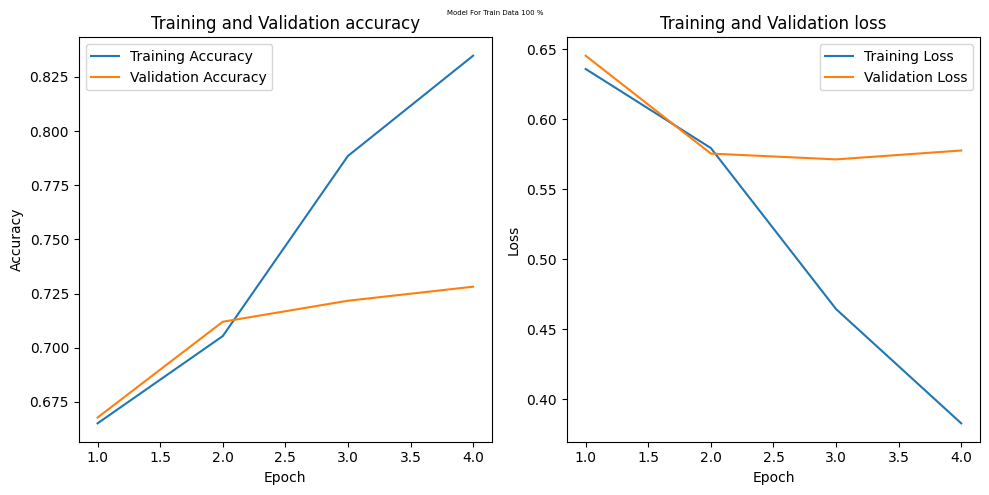

Saving model to the model directory gdrive/MyDrive/./CE807/Assignment2/10/models/1/100


In [ ]:

# starting training
train_method1(train_file,val_file,model_directory1_100)

The shape of vary train data are:
25% train_data:(3078,)
50% train_data:(6156,)
75% train_data:(9234,)
100% train_data:(12313,)
2896      hey   they all cant come to us  come on  we h...
11947     iya risi in my area didnt get the money she i...
8023      keep up the good work you do and ignore the h...
7720     asmr eel sushi salmon sushi eating sounds big ...
2052        divert and defamewe voted him in to get thi...
                               ...                        
938         because im a little concerned about the q f...
11620     tbh these days i just dont like people in gen...
2015       people like you are the greatest campaign to...
8593               but but but all those gun control laws 
12107    party that wants to deport  that are on  growi...
Name: tweet, Length: 9234, dtype: object
---------
vocab 15543
----Building the model----
Setting up the conv layer
Model: "model_3"
_________________________________________________________________
 Layer (type)           

289/289 - 70s - loss: 0.6391 - accuracy: 0.6635 - val_loss: 0.6583 - val_accuracy: 0.6677 - 70s/epoch - 242ms/step
Epoch 2/4

Epoch 2: val_loss improved from 0.65827 to 0.58669, saving model to gdrive/MyDrive/./CE807/Assignment2/10/models/1/75


289/289 - 27s - loss: 0.5901 - accuracy: 0.6984 - val_loss: 0.5867 - val_accuracy: 0.7152 - 27s/epoch - 93ms/step
Epoch 3/4

Epoch 3: val_loss improved from 0.58669 to 0.57560, saving model to gdrive/MyDrive/./CE807/Assignment2/10/models/1/75


289/289 - 24s - loss: 0.4718 - accuracy: 0.7873 - val_loss: 0.5756 - val_accuracy: 0.7217 - 24s/epoch - 82ms/step
Epoch 4/4

Epoch 4: val_loss did not improve from 0.57560
289/289 - 7s - loss: 0.3772 - accuracy: 0.8399 - val_loss: 0.6009 - val_accuracy: 0.7087 - 7s/epoch - 23ms/step
289/289 [==============================] - 2s 5ms/step - loss: 0.2482 - accuracy: 0.9198
Train score: [0.24818526208400726, 0.9197530746459961]
29/29 [==============================] - 0s 7ms/step - loss: 0.6009 - accuracy: 0.7087
Validation score: [0.6008667349815369, 0.708737850189209]
-------------------------------------------------


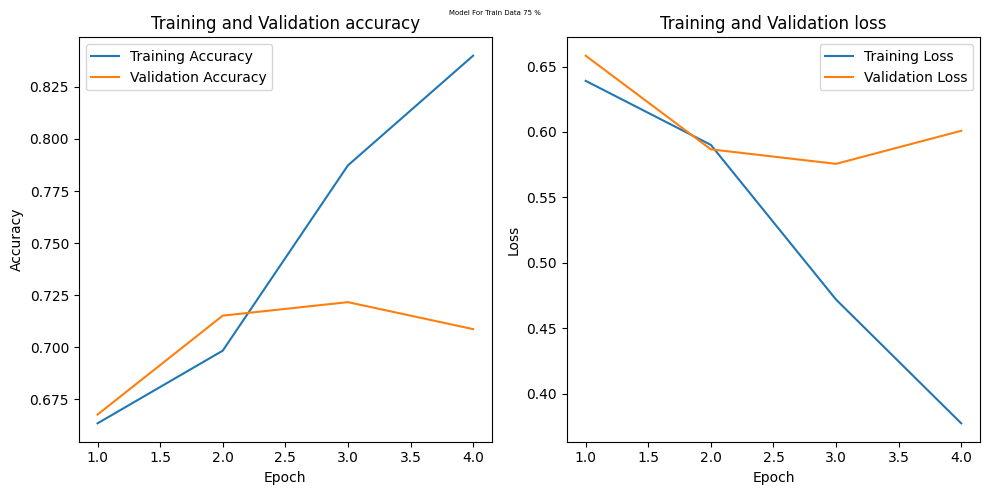

Saving model to the model directory gdrive/MyDrive/./CE807/Assignment2/10/models/1/75


In [ ]:
train_method1(train_file,val_file,model_directory1_75)

The shape of vary train data are:
25% train_data:(3078,)
50% train_data:(6156,)
75% train_data:(9234,)
100% train_data:(12313,)
2896      hey   they all cant come to us  come on  we h...
11947     iya risi in my area didnt get the money she i...
8023      keep up the good work you do and ignore the h...
7720     asmr eel sushi salmon sushi eating sounds big ...
2052        divert and defamewe voted him in to get thi...
                               ...                        
1268             and when logic fails you arent a twitt...
11180    conservatives  theresa_may since my very first...
10774       so have the conservatives accepted the anti...
11713      why isnt the basic issue of survival of the ...
2462      knew it was a lie can see you laughing to you...
Name: tweet, Length: 6156, dtype: object
---------
vocab 12297
----Building the model----
Setting up the conv layer
Model: "model_4"
_________________________________________________________________
 Layer (type)           

193/193 - 56s - loss: 0.6360 - accuracy: 0.6615 - val_loss: 0.6565 - val_accuracy: 0.6677 - 56s/epoch - 288ms/step
Epoch 2/4

Epoch 2: val_loss improved from 0.65655 to 0.62572, saving model to gdrive/MyDrive/./CE807/Assignment2/10/models/1/50


193/193 - 25s - loss: 0.6138 - accuracy: 0.6748 - val_loss: 0.6257 - val_accuracy: 0.6731 - 25s/epoch - 129ms/step
Epoch 3/4

Epoch 3: val_loss improved from 0.62572 to 0.60134, saving model to gdrive/MyDrive/./CE807/Assignment2/10/models/1/50


193/193 - 22s - loss: 0.5216 - accuracy: 0.7547 - val_loss: 0.6013 - val_accuracy: 0.7098 - 22s/epoch - 116ms/step
Epoch 4/4

Epoch 4: val_loss did not improve from 0.60134
193/193 - 4s - loss: 0.3879 - accuracy: 0.8341 - val_loss: 0.6424 - val_accuracy: 0.7012 - 4s/epoch - 21ms/step
193/193 [==============================] - 1s 5ms/step - loss: 0.2435 - accuracy: 0.9287
Train score: [0.2434619963169098, 0.9286874532699585]
29/29 [==============================] - 0s 5ms/step - loss: 0.6424 - accuracy: 0.7012
Validation score: [0.6423645615577698, 0.7011865973472595]
-------------------------------------------------


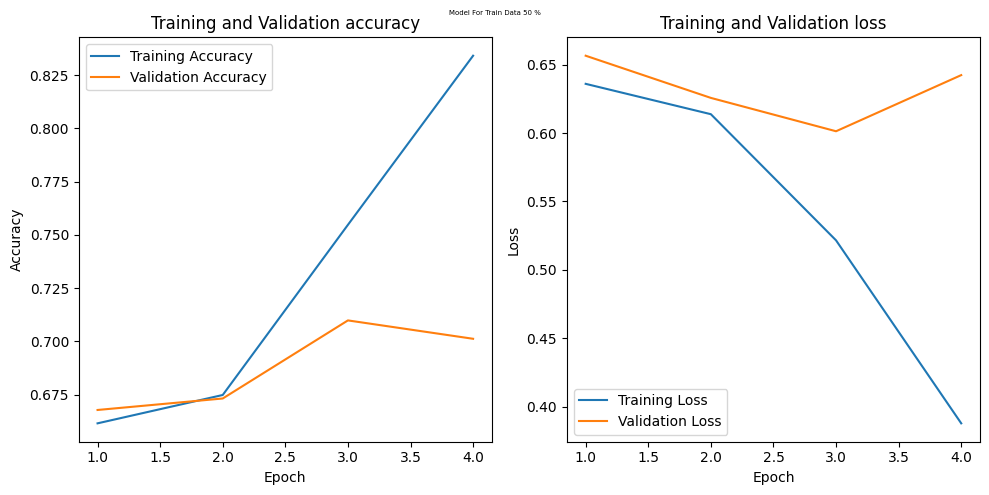

Saving model to the model directory gdrive/MyDrive/./CE807/Assignment2/10/models/1/50


In [ ]:
train_method1(train_file,val_file,model_directory1_50)

The shape of vary train data are:
25% train_data:(3078,)
50% train_data:(6156,)
75% train_data:(9234,)
100% train_data:(12313,)
2896      hey   they all cant come to us  come on  we h...
11947     iya risi in my area didnt get the money she i...
8023      keep up the good work you do and ignore the h...
7720     asmr eel sushi salmon sushi eating sounds big ...
2052        divert and defamewe voted him in to get thi...
                               ...                        
2544       and your fans keep going back and forth betw...
8874       california gun control is direct result of w...
4396      it would make sense for her to be a big chara...
2483       maybe he is making amends before  passes at ...
10404                                      you are funny  
Name: tweet, Length: 3078, dtype: object
---------
vocab 8241
----Building the model----
Setting up the conv layer
Model: "model_5"
_________________________________________________________________
 Layer (type)            

97/97 - 47s - loss: 0.6410 - accuracy: 0.6615 - val_loss: 0.6712 - val_accuracy: 0.6677 - 47s/epoch - 482ms/step
Epoch 2/4

Epoch 2: val_loss did not improve from 0.67117
97/97 - 10s - loss: 0.6268 - accuracy: 0.6644 - val_loss: 0.6741 - val_accuracy: 0.6677 - 10s/epoch - 101ms/step
Epoch 3/4

Epoch 3: val_loss improved from 0.67117 to 0.66369, saving model to gdrive/MyDrive/./CE807/Assignment2/10/models/1/25


97/97 - 23s - loss: 0.5973 - accuracy: 0.6884 - val_loss: 0.6637 - val_accuracy: 0.6775 - 23s/epoch - 235ms/step
Epoch 4/4

Epoch 4: val_loss improved from 0.66369 to 0.64192, saving model to gdrive/MyDrive/./CE807/Assignment2/10/models/1/25


97/97 - 23s - loss: 0.4729 - accuracy: 0.7853 - val_loss: 0.6419 - val_accuracy: 0.6602 - 23s/epoch - 234ms/step
97/97 [==============================] - 1s 5ms/step - loss: 0.4986 - accuracy: 0.9042
Train score: [0.4985648989677429, 0.9041585326194763]
29/29 [==============================] - 0s 5ms/step - loss: 0.6419 - accuracy: 0.6602
Validation score: [0.6419220566749573, 0.6601941585540771]
-------------------------------------------------


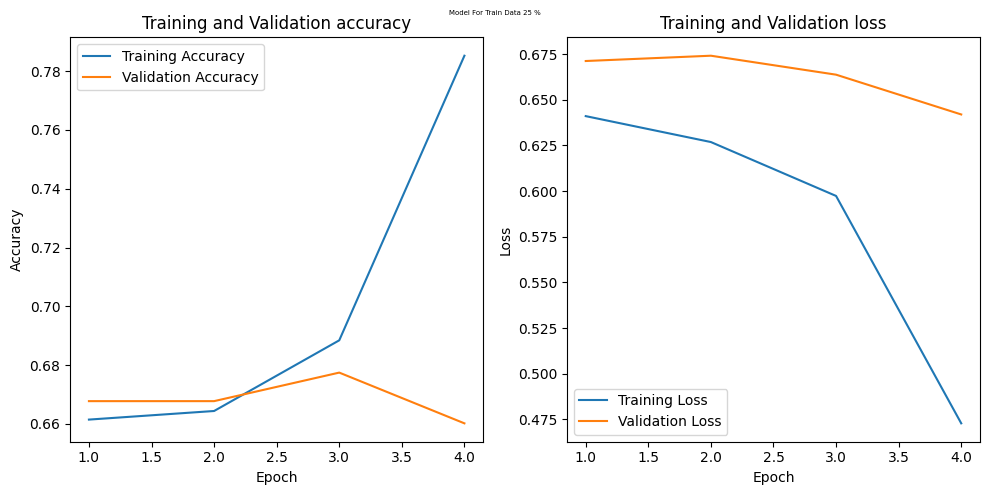

Saving model to the model directory gdrive/MyDrive/./CE807/Assignment2/10/models/1/25


In [ ]:
train_method1(train_file,val_file,model_directory1_25)

27/27 [==============================] - 9s 7ms/step


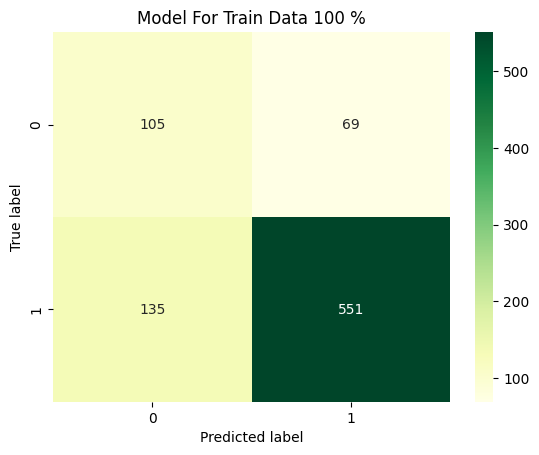

              precision    recall  f1-score   support

   Offensive       0.44      0.60      0.51       174
Notoffensive       0.89      0.80      0.84       686

    accuracy                           0.76       860
   macro avg       0.66      0.70      0.68       860
weighted avg       0.80      0.76      0.78       860

------------
Saving output file to gdrive/MyDrive/./CE807/Assignment2/10/models/1/100


In [ ]:
report_model1_100=test_method1(test_file,model_directory1_100,'output_test.csv')

27/27 [==============================] - 1s 4ms/step


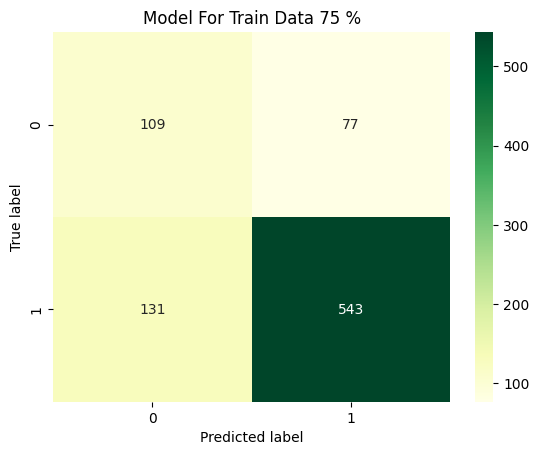

              precision    recall  f1-score   support

   Offensive       0.45      0.59      0.51       186
Notoffensive       0.88      0.81      0.84       674

    accuracy                           0.76       860
   macro avg       0.66      0.70      0.68       860
weighted avg       0.78      0.76      0.77       860

------------
Saving output file to gdrive/MyDrive/./CE807/Assignment2/10/models/1/75


In [ ]:
report_model1_75=test_method1(test_file,model_directory1_75,'output_test.csv')

Exception ignored in: <function UniquePtr.__del__ at 0x7f06fd080d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/framework/c_api_util.py", line 74, in __del__
    self.deleter(obj)
KeyboardInterrupt: 


27/27 [==============================] - 1s 5ms/step


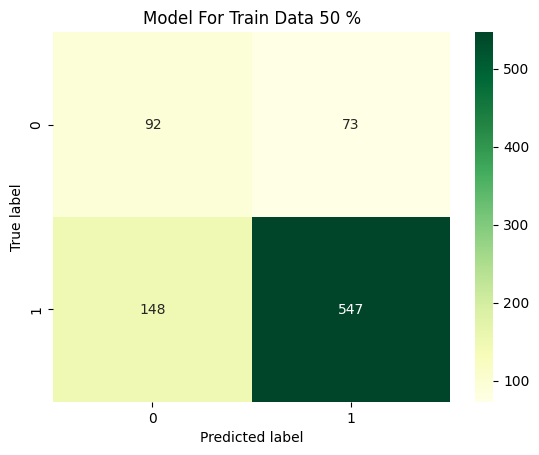

              precision    recall  f1-score   support

   Offensive       0.38      0.56      0.45       165
Notoffensive       0.88      0.79      0.83       695

    accuracy                           0.74       860
   macro avg       0.63      0.67      0.64       860
weighted avg       0.79      0.74      0.76       860

------------
Saving output file to gdrive/MyDrive/./CE807/Assignment2/10/models/1/50


In [ ]:
report_model1_50=test_method1(test_file,model_directory1_50,'output_test.csv')

27/27 [==============================] - 1s 4ms/step


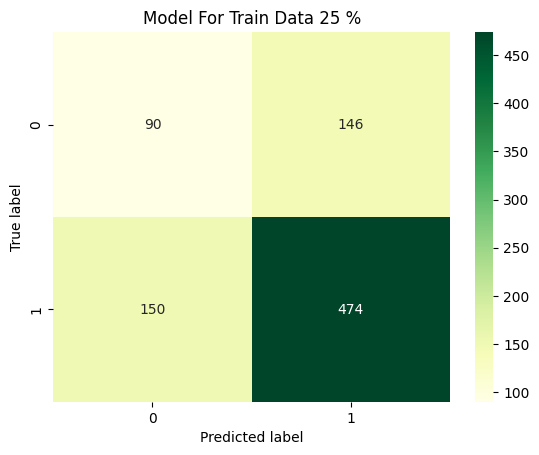

              precision    recall  f1-score   support

   Offensive       0.38      0.38      0.38       236
Notoffensive       0.76      0.76      0.76       624

    accuracy                           0.66       860
   macro avg       0.57      0.57      0.57       860
weighted avg       0.66      0.66      0.66       860

------------
Saving output file to gdrive/MyDrive/./CE807/Assignment2/10/models/1/25


In [ ]:
report_model1_25=test_method1(test_file,model_directory1_25,'output_test.csv')

LSTM model was less accurate in classifying the tweets into offensive and non-offensive categories when trained on a smaller dataset.

The next step is to define the workflow for the BERT classifier with some modifications in the implementation. 

In [ ]:

def method2_tokenize(seq,tokenizer):
  sq_tokenize= tokenizer(seq.tolist(),padding="max_length",truncation=True,max_length=128)
  return sq_tokenize


class torch_dataset_conv(torch.utils.data.Dataset):
  def __init__(self,encodings,labels):
    self.encodings=encodings
    self.labels=labels
  
  def __getitem__(self,idx):
    item = {key:torch.tensor(val[idx]) for key,val in self.encodings.items()}
    item["labels"] = torch.tensor(self.labels[idx])
    return item
  def __len__(self):
    return len(self.labels)



def train_method2(train_file,val_file,model_directory,bert_tokenizer,model):
  x_tr,y_tr=sp_funct(train_file,model_directory)
  vl_tweet , vl_label=val_file['tweet'],val_file['label']

  x_tr_tok=method2_tokenize(x_tr,bert_tokenizer)
  val_train_tok=method2_tokenize(vl_tweet,bert_tokenizer)

  tr_torchds = torch_dataset_conv(x_tr_tok,y_tr.tolist())
  val_torchds=torch_dataset_conv(val_train_tok,vl_label.tolist())

  # setting up the training arguments now

  training_args = TrainingArguments(
    output_dir='None',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=250,
    weight_decay=0.01,
    logging_steps=100,
    overwrite_output_dir=True,
    #evaluation_strategy='epoch',
    load_best_model_at_end=True,
    save_strategy= "steps",
    save_total_limit=2,
    evaluation_strategy='steps')

  trainer = Trainer(model=model,args=training_args,train_dataset=tr_torchds,eval_dataset=val_torchds
      )
  trainer.train()
  print("The last training state is:")
  print(trainer.state.log_history[-1])
  print("----\n\n")
  print(f"Saving the best model to directory: {model_directory}")
  model.save_pretrained(model_directory)
  shutil.rmtree('/content/None')



In [ ]:
def method2_pred_funct(input_ids,attention_mask,model):
  input_ids = torch.tensor(input_ids).to(device)
  attention_mask = torch.tensor(attention_mask).to(device)
  with torch.no_grad():
      outputs = model(input_ids.unsqueeze(0),attention_mask.unsqueeze(0))
  y_pred = np.argmax(outputs[0].to('cpu').numpy())
  y_prob = torch.nn.functional.softmax(outputs[0],dim=-1)[0][y_pred].to('cpu').numpy()
  return y_pred,y_prob



def test_method2(test_file,model_file,output,tokenizer):
  
  model=BertForSequenceClassification.from_pretrained(model_file,num_labels=2).to(device)
  test_tweet , test_label=test_file['tweet'],test_file['label']
  
  test_tok=method2_tokenize(test_tweet,bert_tokenizer)
  
  predictions_test=[]
  for i in range(len(test_tok['input_ids'])) :
    op,p_op = method2_pred_funct(test_tok['input_ids'][i],test_tok['attention_mask'][i],model)
    predictions_test.append(op)
  
  # printing prediction statistics
  plot_confusion_matrix(predictions_test , test_label, model_file)

  report_non_dict=classification_report(predictions_test, test_label, target_names=['Offensive','Notoffensive'])
  print(report_non_dict)
  report_dict=classification_report(predictions_test, test_label, target_names=['Offensive','Notoffensive'],output_dict=True)
  print("The Accuracy Score")

  print(accuracy_score(predictions_test,test_label))

  print("")
  test_file['out_label']=predictions_test
  test_file['out_label']=test_file['out_label'].replace([0,1],['OFF','NOT'])
  output_directory=os.path.join(model_file,output)
  test_file.to_csv(output_directory,index=False)
  return report_dict



  



In [ ]:
model_directory2_100=f"gdrive/MyDrive/./CE807/Assignment2/{str(student_id)}/models/2/100"
model_directory2_75=f"gdrive/MyDrive/./CE807/Assignment2/{str(student_id)}/models/2/75"
model_directory2_50=f"gdrive/MyDrive/./CE807/Assignment2/{str(student_id)}/models/2/50"
model_directory2_25=f"gdrive/MyDrive/./CE807/Assignment2/{str(student_id)}/models/2/25"

In [ ]:
train_file,test_file,val_file=reading_dataset(tr_p,ts_p,val_p)

train_file=cl_enc(train_file)
test_file=cl_enc(test_file)
val_file=cl_enc(val_file)
print(train_file.head())

bert_tokenizer=BertTokenizerFast.from_pretrained('bert-base-uncased')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2).to(device)


      id                                              tweet  label
0  42884   im done with you as well an intentional 11th ...      1
1  92152  i now have over 6k followers  only 94k to go t...      1
2  65475   tom was bought he is more interested in tom t...      1
3  22144          even her brother thinks she is a monster       0
4  81048       i can understand that and if its someone ...      0


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
train_method2(train_file,val_file,model_directory2_100,bert_tokenizer,model)

In [ ]:
train_method2(train_file,val_file,model_directory2_75,bert_tokenizer,model)

The shape of vary train data are:
25% train_data:(3078,)
50% train_data:(6156,)
75% train_data:(9234,)
100% train_data:(12313,)


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
100,0.312500,0.474294
200,0.320100,0.491103
300,0.326700,0.636322
400,0.230800,0.558694
500,0.233000,0.586748
600,0.209700,0.761928
700,0.100500,0.937643
800,0.115300,0.887617


The last training state is:
{'train_runtime': 594.6168, 'train_samples_per_second': 46.588, 'train_steps_per_second': 1.458, 'total_flos': 1822175613895680.0, 'train_loss': 0.22187616530861684, 'epoch': 3.0, 'step': 867}
----


Saving the best model to directory: gdrive/MyDrive/./CE807/Assignment2/10/models/2/75


In [ ]:
train_method2(train_file,val_file,model_directory2_50,bert_tokenizer,model)

The shape of vary train data are:
25% train_data:(3078,)
50% train_data:(6156,)
75% train_data:(9234,)
100% train_data:(12313,)


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
100,0.162400,0.625904
200,0.129900,0.853396
300,0.116900,0.812423
400,0.117000,0.898147
500,0.062700,0.950262


The last training state is:
{'train_runtime': 394.857, 'train_samples_per_second': 46.771, 'train_steps_per_second': 1.466, 'total_flos': 1214783742597120.0, 'train_loss': 0.10801110778241989, 'epoch': 3.0, 'step': 579}
----


Saving the best model to directory: gdrive/MyDrive/./CE807/Assignment2/10/models/2/50


In [ ]:
train_method2(train_file,val_file,model_directory2_25,bert_tokenizer,model)

The shape of vary train data are:
25% train_data:(3078,)
50% train_data:(6156,)
75% train_data:(9234,)
100% train_data:(12313,)


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
100,0.036400,1.140816
200,0.039300,1.205972


The last training state is:
{'train_runtime': 191.8985, 'train_samples_per_second': 48.119, 'train_steps_per_second': 1.516, 'total_flos': 607391871298560.0, 'train_loss': 0.039352990507669876, 'epoch': 3.0, 'step': 291}
----


Saving the best model to directory: gdrive/MyDrive/./CE807/Assignment2/10/models/2/25


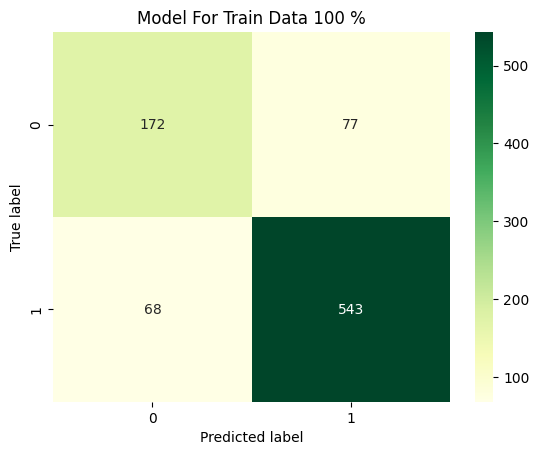

              precision    recall  f1-score   support

   Offensive       0.72      0.69      0.70       249
Notoffensive       0.88      0.89      0.88       611

    accuracy                           0.83       860
   macro avg       0.80      0.79      0.79       860
weighted avg       0.83      0.83      0.83       860

The Accuracy Score
0.8313953488372093



In [ ]:
report_model2_100=test_method2(test_file,model_directory2_100,'output_test.csv',bert_tokenizer)

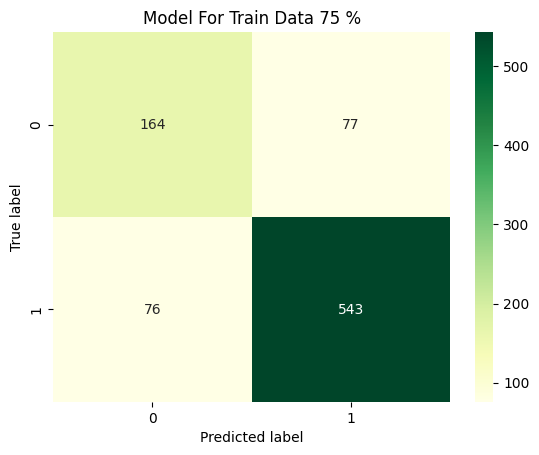

              precision    recall  f1-score   support

   Offensive       0.68      0.68      0.68       241
Notoffensive       0.88      0.88      0.88       619

    accuracy                           0.82       860
   macro avg       0.78      0.78      0.78       860
weighted avg       0.82      0.82      0.82       860

The Accuracy Score
0.8220930232558139



In [ ]:
report_model2_75=test_method2(test_file,model_directory2_75,'output_test.csv',bert_tokenizer)

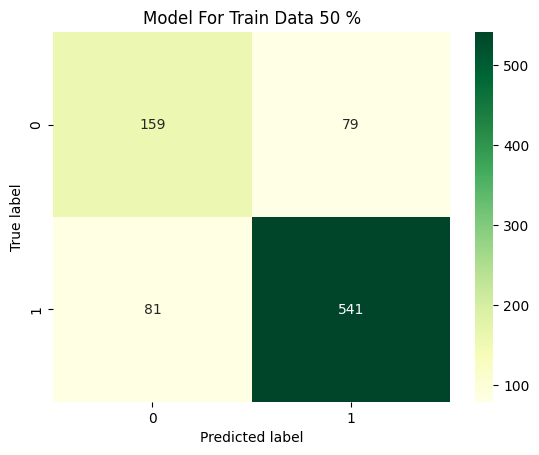

              precision    recall  f1-score   support

   Offensive       0.66      0.67      0.67       238
Notoffensive       0.87      0.87      0.87       622

    accuracy                           0.81       860
   macro avg       0.77      0.77      0.77       860
weighted avg       0.81      0.81      0.81       860

The Accuracy Score
0.813953488372093



In [ ]:
report_model2_50=test_method2(test_file,model_directory2_50,'output_test.csv',bert_tokenizer)

Bert Classifier performance also slightly decline by lower the train data size

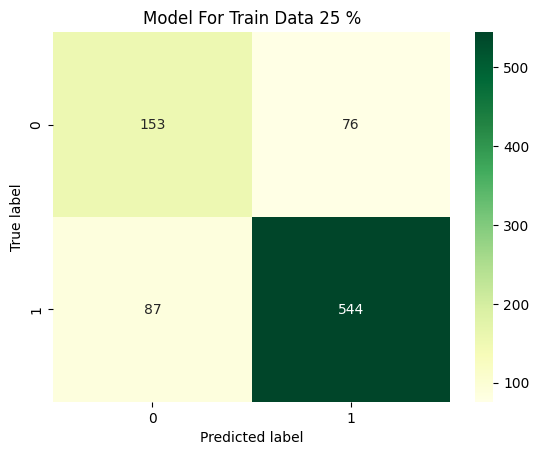

              precision    recall  f1-score   support

   Offensive       0.64      0.67      0.65       229
Notoffensive       0.88      0.86      0.87       631

    accuracy                           0.81       860
   macro avg       0.76      0.77      0.76       860
weighted avg       0.81      0.81      0.81       860

The Accuracy Score
0.8104651162790698



In [ ]:
report_model2_25=test_method2(test_file,model_directory2_25,'output_test.csv',bert_tokenizer)

 Comapring the F1 scores of both models measured on different data sizes and plot them to observe the effect of the train size on test data prediction.

In [ ]:
x_size=[100,75,50,25]

model_1_reports=[report_model1_100,
report_model1_75,
report_model1_50,
report_model1_25]

model_1_f1=[x['accuracy'] for x in model_1_reports]

model_2_reports=[report_model2_100,
                report_model2_75,
                report_model2_50,
                report_model2_25
                ]

model_2_f1=[x['accuracy'] for x in model_2_reports]



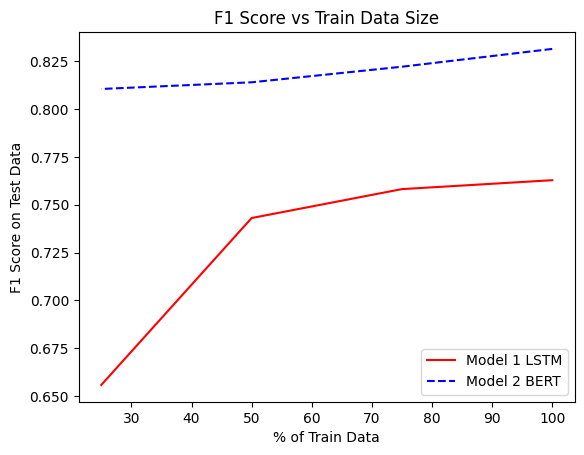

In [ ]:

plt.plot(x_size, model_1_f1,'r-',label='Model 1 LSTM')
plt.plot(x_size, model_2_f1,'b--', label='Model 2 BERT')
plt.xlabel('% of Train Data')
plt.ylabel('F1 Score on Test Data')
plt.title('F1 Score vs Train Data Size')

plt.legend()

plt.show()

In [ ]:
def acc_table(reports_list,clasifier_name):
  final_df=pd.DataFrame()
  train_data_size=['100%','75%','50%','25%']
  for idx,report in enumerate(reports_list):
    data_size=train_data_size[idx]
    cols=['precision','recall','f1-score']
    keys=['Offensive','Notoffensive']
    val=[]
    for key in keys:
      val.append([data_size,key,report[key][cols[0]],report[key][cols[1]],report[key][cols[2]]])
    
    df=pd.DataFrame(val,columns=['Train Data Size','Class']+cols)
    df['Overall Accuracy']=report['accuracy']
    df['Classifier Name']=clasifier_name
    final_df=pd.concat([final_df,df])
  return final_df

df1=acc_table(model_1_reports,'LSTM')
df2=acc_table(model_2_reports,'BERT')

df3=pd.concat([df1,df2]).reset_index(drop=True)

In [ ]:
df3

,Train Data Size,Class,precision,recall,f1-score,Overall Accuracy,Classifier Name
0,100%,Offensive,0.437500,0.603448,0.507246,0.762791,LSTM
1,100%,Notoffensive,0.888710,0.803207,0.843798,0.762791,LSTM
2,75%,Offensive,0.454167,0.586022,0.511737,0.758140,LSTM
3,75%,Notoffensive,0.875806,0.805638,0.839258,0.758140,LSTM
4,50%,Offensive,0.383333,0.557576,0.454321,0.743023,LSTM
5,50%,Notoffensive,0.882258,0.787050,0.831939,0.743023,LSTM
6,25%,Offensive,0.375000,0.381356,0.378151,0.655814,LSTM
7,25%,Notoffensive,0.764516,0.759615,0.762058,0.655814,LSTM
8,100%,Offensive,0.716667,0.690763,0.703476,0.831395,BERT
9,100%,Notoffensive,0.875806,0.888707,0.882210,0.831395,BERT


In [ ]:
df3.to_csv("/content/table_assign2.csv",index=False)

As the size of the training data increases, the model's performance tends to improve, and it becomes more accurate in classifying the tweets into offensive or non-offensive categories.